In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False

순환 신경망(Recurrent Neural Network, RNN)

순환 신경망은 시퀀스(sequence) 데이터를 사용한다. 시퀀스 데이터는 다른 말로 시계열(time serise) 데이터라고도 말하며, 시점에 따라서 데이터가 달라지는 것을 의미한다. 즉, 특정 시점에서 데이터를 한 번에 수집하는 것이 아닌 시간의 흐름에 따라 데이터를 점차 수집하는 것을 의미한다. 전체 데이터셋을 구성하는 각 데이터 포인트의 수집 시점이 다르다.

지금까지 다룬 신경망은 입력 데이터를 사용한 후 그 결과가 다시 입력층으로 돌아가지 않았다. 즉, 한 번 출력된 결과를 다시 사용되지 않았다. 이를 피드포워드(feedforward) 신경망이라 한다. 반면에 순환 신경망은 출력된 결과가 다음 시점에서 사용된다. 즉, 출력 결과를 다음 시점까지 기억했다가 사용하는 방식이다.

<img src="./images/rnn_1.png/" width="700"/>

LSTM(Long Short Term Memory)

순환 신경망은 은닉층을 거친 결과값을 재사용하는 특징이 있다. 그러나 그로 인해서 기울기 소멸 문제(vanishing gradient problem)나 기울기 폭주 문제(exploding gradient problem)가 발생할 수 있다. 기울기 소멸 문제는 학습이 진행되는 과정에서 기울기 점점 줄어들어 사라지는 현상을 의미하고 기울기 폭주는 학습 과정에서 기울기가 점점 커져서 폭주하는 현상을 말한다.

LSTM은 기울기 소멸이나 폭주 문제를 해결하기 위해 만든 방법이다. LSTM에서는 결과값이 다음 시점으로 넘어갈 때 결과값을 넘길지 말지 결정하는 단계가 추가된다.

<img src="./images/rnn_2.png/" width="800"/>

순환 신경망 실습  
순환 신경망을 이용해 영화 리뷰 감성 분석을 해본다. 

In [2]:
# 일관된 결과값이 나오도록 random seed를 설정한다.
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

IMDB Movie Review Sentiment Analysis  
감성 분류를 연습하기 위해 자주 사용하는 영어 데이터로 영화 사이트 IMBD 리뷰 데이터가 있다.  
이 데이터는 리뷰에 대한 텍스트와 리뷰가 긍정인 경우 1을 부정인 경우 0으로 표시한 레이블로 구성된 데이터로 스탠포드 대학교에서 2011년에 낸 논문에서 이 데이터를 소개하였으며, 당시 논문에서는 이 데이터를 훈련 데이터와 테스트 데이터를 50:50 비율로 분할하여 88.89%의 정확도를 얻었다고 소개하고 있다.  

In [3]:
# 데이터 불러오기
from tensorflow.keras import datasets # 텐서플로우가 제공하는 데이터셋을 사용하기 위해 import 한다.
# mnist 손글씨 데이터는 트레이닝 데이터와 테스트 데이터가 나눠서 저장되어 있다.
# load_data() 메소드는 (트레이닝 피쳐 데이터, 트레이닝 타겟 데이터)와 (테스트 피쳐 데이터, 테스트 타겟 데이터)를
# 튜플 형태로 묶어서 리턴한다.
(X_train, y_train), (X_test, y_test) = datasets.imdb.load_data(num_words=2000) # 영화 리뷰 데이터셋을 피쳐, 타겟 데이터로 저장한다.

In [4]:
datasets.imdb.load_data()

((array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
         list([1, 19

In [5]:
# 오리지널 데이터 확인
# 트레이닝 피쳐 데이터의 차원을 확인하면 (이미지 개수, 행, 열) 형태로 나온다.
# 즉, 트레이닝 피쳐 데이터는 28행 * 28열의 이미지 60,000개로 구성되어 있는 것을 알 수 있다.
print(X_train.shape)
print(y_train.shape) # 트레이닝 타겟 데이터는 스칼라값 60,000개로 이루어진 벡터이다.
print(X_test.shape) # 테스트 피쳐 데이터는 28행 * 28열의 이미지 60,000개로 구성되어 있는 것을 알 수 있다.
print(y_test.shape) # 테스트 타겟 데이터는 스칼라값 10,000개로 이루어진 벡터이다.

(25000,)
(25000,)
(25000,)
(25000,)


In [6]:
# 트레이닝 데이터를 트레이닝 데이터셋과 벨리데이션 데이터셋으로 분리 
# 총 25,000개의 트레이닝 피쳐 데이터 중 20,000개의 데이터를 트레이닝 피쳐 데이터로 지정한다.
X_tr = X_train[:20000]
# 총 25,000개의 트레이닝 피처 데이터 중에서 피쳐 데이터 20,000개를 제외하고 남은 5,000개의 트레이닝 피쳐 데이터를 
# 밸리데이션 피쳐 데이터로 지정한다.
X_valid = X_train[20000:]
print(X_tr.shape, X_valid.shape)
# 총 25,000개의 트레이닝 타겟 데이터 중 20,000개의 데이터를 트레이닝 타겟 데이터로 지정한다.
y_tr = y_train[:20000]
# 총 25,000개의 트레이닝 타겟 데이터 중에서 피쳐 데이터 20,000개를 제외하고 남은 5,000개의 트레이닝 피쳐 데이터를
# 밸리데이션 타겟 데이터로 지정한다.
y_valid = y_train[20000:]
print(y_tr.shape, y_valid.shape)

(20000,) (5000,)
(20000,) (5000,)


In [7]:
# 피쳐 데이터 형태 확인
# 트레이닝 피쳐 데이터 값을 확인해보면 숫자로 이루어진 리스트라는 것을 볼 수 있다.
# 이는 오리지널 데이터에 이미 단어를 숫자 매핑해 놓아 영어 단어가 해당하는 숫자로 변환된 것임을 알 수 있다.
print(X_tr[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 1920, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [8]:
# 개별 피쳐 데이터 크기 확인
# 피쳐 데이터의 가장 처음 나오는 두 개의 피쳐값을 확인해 본 결과 문장의 길이가 다르다는 것을 의미하며 나중에 같은
# 크기로 조정이 필요한다.
print(len(X_tr[0]))
print(len(X_tr[1]))

218
189


In [9]:
# 타겟 클래스 확인
# 타겟 클래스 구분은 0과 1로 2개로 이루어진 
print(set(y_train), set(y_test))

{0, 1} {0, 1}


In [10]:
# 피쳐 데이터 변형
# RNN은 항상 같은 길이의 시퀀스를 받아야하기 때문에 제각기 다른 피쳐 데이터 값의 길이를 일치한다. 
from tensorflow.keras.preprocessing import sequence # 피쳐 데이터 값의 길이를 일치시키기 위해 import 한다. 
# pad_sequences() 메소드로 피쳐 데이터 값의 길이를 일치시킨다. maxlen 속성으로 길이를 지정할 수 있다. 
# 길이를 지정하지 않으면 가장 큰 길이가 기본값으로 사용되고 길이를 맞추고 남는 부분에는 0이 패딩으로 채워진다. 
# 길이를 지정하면 지정한 길이 만큼만 저장되고 나머지는 삭제된다. 
X_tr = sequence.pad_sequences(X_tr, maxlen=100)
X_valid = sequence.pad_sequences(X_valid, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)
print(X_tr.shape, X_valid.shape, X_test.shape)

(20000, 100) (5000, 100) (25000, 100)


In [11]:
# LSTM 신경망 생성에 필요한 라이브러리 import
from tensorflow.keras.models import Sequential # 신경망 모형 생성을 하기 위해 import 한다.
# 각종 층을 쌓기 위해 필요한 모듈을 import 한다.
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, MaxPooling1D

In [12]:
# LSTM 모형을 만든다.
model = Sequential()
# 임베딩이란 사람이 쓰는 자연어를 기계가 이해할 수 있는 숫자의 나열인 벡터로 바꾼 결과 혹은 과정 전체를 의미한다.
# 임베딩이 가장 간단한 형태는 단어의 빈도를 그대로 벡터로 사용하는 것이다.
# 총 2,000개의 단어를 사용하므로 input_dim 옵션은 2,000을 지정하고 데이터 길이는 pad_sequences() 함수를 사용해 
# 100개로 맞췄으므로 output_dim 옵션은 100을 지정한다.
model.add(Embedding(input_dim=2000, output_dim=100)) # 단어 임베딩 층을 추가한다.
# Param은 input_dim * output_dim = 2000 * 100 => 200000
# CNN은 2차원 데이터를 이용하서 Conv2D를 사용했지만 LSTM은 1차원 데이터가 입력되므로 Conv1D를 사용한다.
model.add(Conv1D(filters=50, kernel_size=3, padding='valid', activation='relu')) # 합성곱 층을 추가한다.
# Param은 커널 크기(3) * 입력 채널 수(100) * 필터 수(50) + 출력 채널 바이어스(50) = 3 * 100 * 50 + 50 = 15050
model.add(MaxPooling1D(pool_size=3)) # 맥스 풀링 층을 추가한다.
model.add(LSTM(units=100, activation='tanh')) # LSTM 층을 추가한다. LSTM 층은 4개이다.
# Param은 (출력 개수(100) + 입력 개수(50) + 바이어스(1)) * 출력 개수(100) * 4 = (100 + 50 + 1) * 100 * 4
# = 151 * 100 * 4 = 60400
model.add(Dropout(0.25)) # 드롭아웃 층을 추가한다.
model.add(Dense(1, activation='sigmoid')) # 최종 출력층을 추가해주면 순환 신경망이 완성된다.
# # Param은 입력 개수(100) * 출력 개수(1) + 출력 개수와 같은 바이어스(1) = 100 * 1 + 1 = 101
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         200000    
                                                                 
 conv1d (Conv1D)             (None, None, 50)          15050     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 50)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                        

In [13]:
# 모델 컴파일
# 분류 신경망은 loss 속성에 손실(비용, 오차)함수를 지정할 때 이진 분류 문제 binary_crossentropy를 지정하고, 
# 3개 이상의 클래스로 분류하는 다중 분류 문제에서는 categorical_crossentropy를 지정한다.
# optimizer 속성에 최적화 함수(일반적으로 adam)를 지정한다.
# metrics 속성에 평가 기준을 지정한다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# 신경망 학습
hist = model.fit(X_tr, y_tr, epochs=10, batch_size=100, validation_data=(X_valid, y_valid))

Epoch 1/10
200/200 [==============================] - 14s 59ms/step - loss: 0.4879 - accuracy: 0.7466 - val_loss: 0.3845 - val_accuracy: 0.8294
Epoch 2/10
200/200 [==============================] - 12s 61ms/step - loss: 0.3418 - accuracy: 0.8518 - val_loss: 0.3718 - val_accuracy: 0.8308
Epoch 3/10
200/200 [==============================] - 13s 64ms/step - loss: 0.3009 - accuracy: 0.8747 - val_loss: 0.3724 - val_accuracy: 0.8348
Epoch 4/10
200/200 [==============================] - 12s 61ms/step - loss: 0.2584 - accuracy: 0.8964 - val_loss: 0.3791 - val_accuracy: 0.8344
Epoch 5/10
200/200 [==============================] - 12s 59ms/step - loss: 0.2062 - accuracy: 0.9227 - val_loss: 0.4110 - val_accuracy: 0.8266
Epoch 6/10
200/200 [==============================] - 12s 60ms/step - loss: 0.1366 - accuracy: 0.9513 - val_loss: 0.4686 - val_accuracy: 0.8234
Epoch 7/10
200/200 [==============================] - 12s 61ms/step - loss: 0.0861 - accuracy: 0.9714 - val_loss: 0.6753 - val_accuracy:

In [15]:
# 모델 평가
print(model.evaluate(X_tr, y_tr))
print(model.evaluate(X_valid, y_valid))
print(model.evaluate(X_test, y_test))

625/625 [==============================] - 5s 8ms/step - loss: 0.0071 - accuracy: 0.9987
[0.007111974526196718, 0.9986500144004822]
157/157 [==============================] - 1s 7ms/step - loss: 0.9193 - accuracy: 0.8104
[0.9193267822265625, 0.8104000091552734]
782/782 [==============================] - 5s 7ms/step - loss: 0.8959 - accuracy: 0.8174
[0.8958622813224792, 0.817359983921051]


NameError: name 'epoch' is not defined

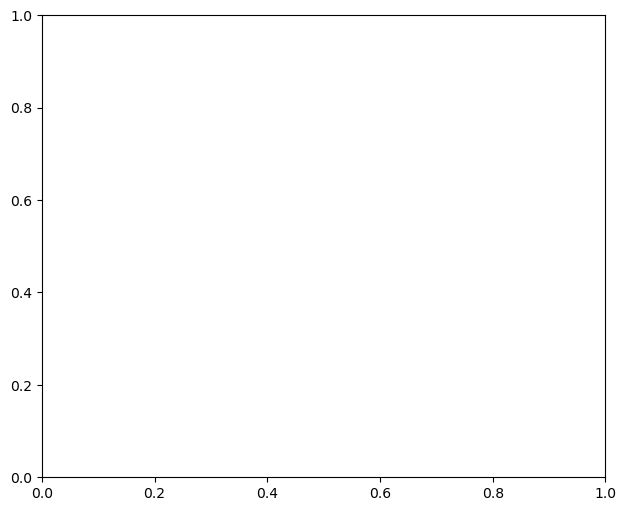

In [16]:
import matplotlib.pyplot as plt

acc_train = hist.history['accuracy'] # 트레이닝 데이터의 정확도를 저장한다.
acc_valid = hist.history['val_accuracy'] # 밸리데이션 데이터의 정확도를 저장한다.
loss_train = hist.history['loss'] # 트레이닝 데이터의 손실 정도를 저장한다.
loss_valid = hist.history['val_loss'] # 밸리데이션 데이터의 손실 정도를 저장한다.

plt.figure(figsize=(16, 6))
# 정확도 시각화 
plt.subplot(1, 2, 1) # 정확도를 출력할 서브 플롯
plt.plot(epoch, acc_train, 'b', marker='o', label='train_acc')
plt.plot(epoch, acc_valid, 'r--', marker='^', label='valid_acc')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
# 손실 시각화.
plt.subplot(1, 2, 2) # 손실을 출력할 서브 플롯
plt.plot(epoch, loss_train, 'b', marker='o', label='train_loss')
plt.plot(epoch, loss_valid, 'r--', marker='^', label='valid_loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()